In [1]:
import contextlib

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
@contextlib.contextmanager
def add_subplots(rows: int, cols: int, figsize: tuple[int] = (8, 6)):
    _, axes = plt.subplots(rows, cols, figsize=figsize)
    yield axes

In [4]:
hse_df = pd.read_json("parsed_results/hse_data.json", orient="records")
itmo_df = pd.read_json("parsed_results/itmo_data.json", orient="records")

In [5]:
hse_df.head(n=1)

,title,educational_programme,year,abstract,level,faculty
0,Разработка программы управленческих действий п...,Управление образованием,2016,\n\tТема исследования: Разработка программы уп...,(Магистратура),Институт образования


In [6]:
itmo_df.head(n=1)

,title,educational_programme,year,abstract,level,faculty
0,РАЗРАБОТКА МЕТОДА УДАЛЕНИЯ ОШИБОК ИЗ НАБОРА ЧТ...,010500 Прикладная математика и информатика,2011,Введение. Многие современные задачи биологии и...,бакалавр,Факультет информационных технологий и программ...


## clear data

In [7]:
def has_no_numbers(text: str) -> bool:
    return not any(char.isdigit() for char in text)

assert has_no_numbers("hello!!!")
assert not has_no_numbers("123")
assert not has_no_numbers("HELLO 123")
assert has_no_numbers("")

In [8]:
def take_text_titles(df: pd.DataFrame) -> pd.DataFrame:
    return df.loc[df["title"].map(has_no_numbers)]

In [9]:
for df in [hse_df, itmo_df]:
    print(f"before filter: {len(df)}, after filter: {len(take_text_titles(df))}")

before filter: 47221, after filter: 44538
before filter: 1561, after filter: 1458


In [10]:
def remove_numbers(text: str) -> str:
    return "".join(filter(lambda char: not char.isdigit(), text))

assert remove_numbers("hello") == "hello"
assert remove_numbers("1231923") == ""
assert remove_numbers("hello 123") == "hello "
assert remove_numbers("") == ""

In [11]:
def apply_to_column(df: pd.DataFrame, function, column: str) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy[column] = df_copy[column].map(function)
    return df_copy

In [12]:
for df in [hse_df, itmo_df]:
    transformed_df = apply_to_column(df, remove_numbers, column="educational_programme")
    changed_num = (df["educational_programme"] != transformed_df["educational_programme"]).sum()
    print(f"Changed {changed_num}")

Changed 0
Changed 1560


In [13]:
def unify_level(level: str) -> str:
    if "бакалавр" in level.lower():
        return "bachelor"
    elif "магистр" in level.lower():
        return "master"
    else:
        return "unknown"
    
assert unify_level("(БаКаЛаВрИаТ)") == "bachelor"
assert unify_level("Магистр") == "master"
assert unify_level("Йожик") == "unknown"

In [14]:
for df in [hse_df, itmo_df]:
    transformed_df = apply_to_column(df, unify_level, column="level")
    print(transformed_df["level"].value_counts())

bachelor    28932
master      17711
unknown       578
Name: level, dtype: int64
master      784
bachelor    507
unknown     270
Name: level, dtype: int64


In [15]:
def take_known_levels(df: pd.DataFrame):
    return df.loc[df["level"].isin(["bachelor", "master"])]

In [16]:
def remove_punctuation(text: str, whitelisted_symbols=(" ",)) -> str:
    return "".join(filter(lambda char: char.isalpha() or char in whitelisted_symbols, text))

assert remove_punctuation("hello!!!") == "hello"
assert remove_punctuation("hello, mister freeman", whitelisted_symbols=(" ", ",")) == "hello, mister freeman"
assert remove_punctuation("1*&@!#80123890") == ""

In [17]:
def extract_itmo_faculty(text: str) -> str:
    if "," not in text:
        return text
    
    faculty_parts = [part for part in text.split(",") if "факультет" in part.lower()]
    if len(faculty_parts) > 0 and faculty_parts[0].strip():
        return faculty_parts[0].strip()
    
    return text

assert extract_itmo_faculty("Факультет точной механики и технологии, кафедра измерительных технологий и компьютерной томографии") == \
    "Факультет точной механики и технологии"
assert extract_itmo_faculty("Естественно-научный факультет, кафедра высшей математики") == \
    "Естественно-научный факультет"
assert extract_itmo_faculty("Инженерно-физический факультет, кафедра лазерных технологий и экологического приборостроения") == \
    "Инженерно-физический факультет"

In [18]:
def final_transform(df: pd.DataFrame) -> pd.DataFrame:
    df = take_text_titles(df)
    df = apply_to_column(df, remove_numbers, column="educational_programme")
    df = apply_to_column(df, unify_level, column="level")
    df = apply_to_column(df, remove_punctuation, column="educational_programme")
    df = apply_to_column(df, lambda text: text.strip(), column="educational_programme")
    df = apply_to_column(df, extract_itmo_faculty, column="faculty")
    df = take_known_levels(df)

    return df

In [19]:
transformed_hse_df = final_transform(hse_df)
transformed_itmo_df = final_transform(itmo_df)

print(f"HSE: {len(transformed_hse_df)} rows")
print(f"ITMO: {len(transformed_itmo_df)}")

HSE: 43981 rows
ITMO: 1212


## plot distributions

In [20]:
def rename_title(name: str):
    if name == "title":
        return "count"
    return name

In [21]:
def plot_year_distriubtion(df: pd.DataFrame, title: str, ax):
    sns.countplot(x="year", data=df, ax=ax, color="b")
    ax.set_title(title)

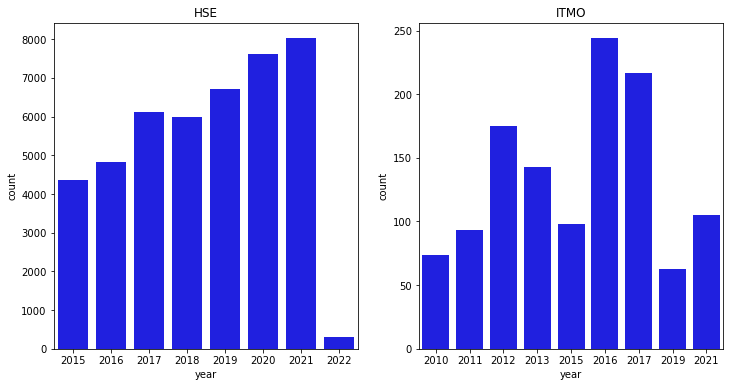

In [22]:
with add_subplots(1, 2, figsize=(12, 6)) as (hse_ax, itmo_ax):
    plot_year_distriubtion(transformed_hse_df, "HSE", hse_ax)
    plot_year_distriubtion(transformed_itmo_df, "ITMO", itmo_ax)

In [23]:
print("HSE programmes:", transformed_hse_df["educational_programme"].nunique())
print("ITMO programmes:", transformed_itmo_df["educational_programme"].nunique())
print()

print("HSE faculties:", transformed_hse_df["faculty"].nunique())
print("ITMO faculties:", transformed_itmo_df["faculty"].nunique())
print()

HSE programmes: 248
ITMO programmes: 139

HSE faculties: 47
ITMO faculties: 56



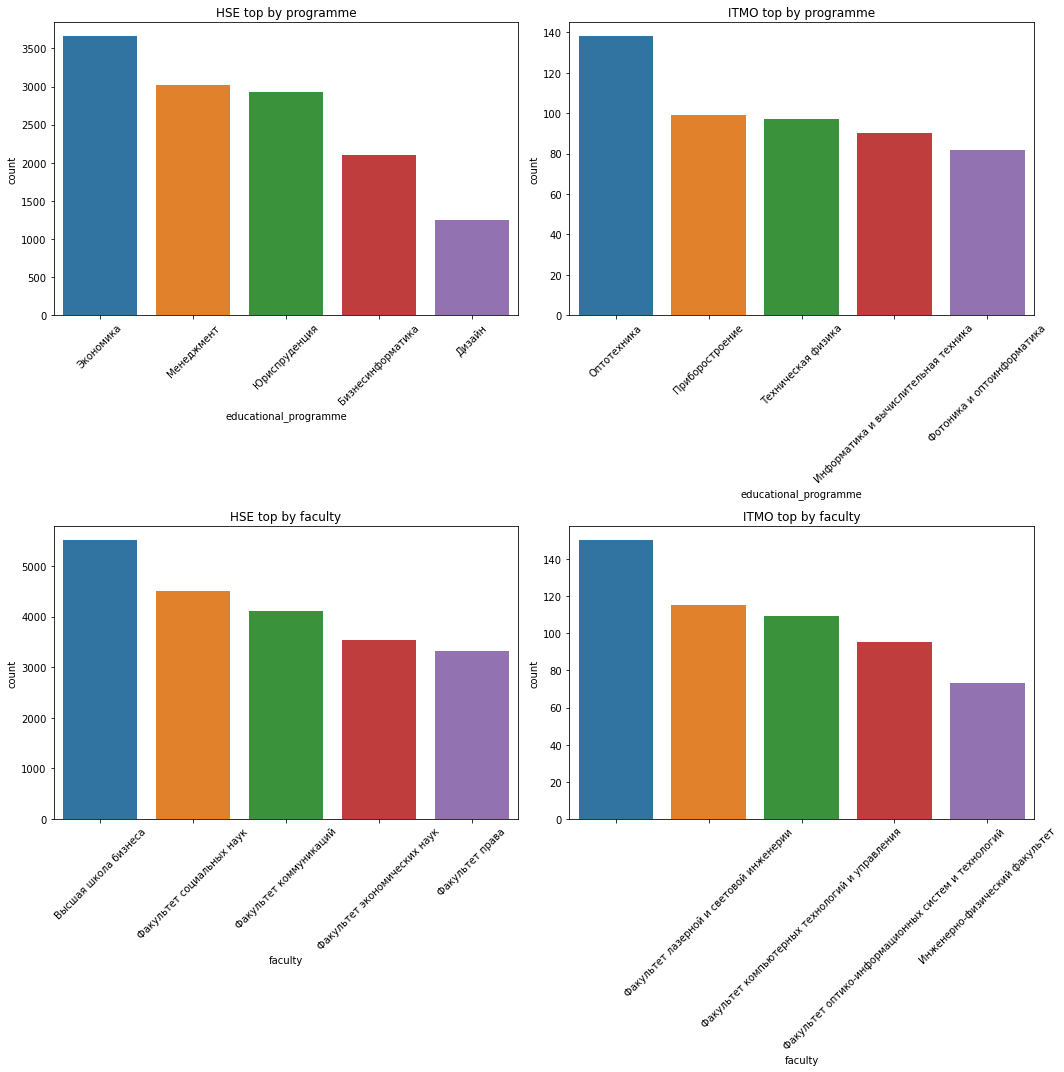

In [24]:
def plot_diplomas_by(df: pd.DataFrame, column: str, title: str, ax, first_n: int = 5):
    groups = df[[column, "title"]].groupby(column, as_index=False).count().rename(columns=rename_title)
    groups = groups.sort_values(by="count", ascending=False)
    top_values = groups[:first_n]

    ax.set_title(title)
    sns.barplot(x=column, y="count", data=top_values, ax=ax)

    for item in ax.get_xticklabels():
        item.set_rotation(45)


with add_subplots(2, 2, figsize=(15, 15)) as ((hse_prog, itmo_prog), (hse_fac, itmo_fac)):
    plot_diplomas_by(transformed_hse_df, column="educational_programme", title="HSE top by programme", ax=hse_prog)
    plot_diplomas_by(transformed_itmo_df, column="educational_programme", title="ITMO top by programme", ax=itmo_prog)
    plot_diplomas_by(transformed_hse_df, column="faculty", title="HSE top by faculty", ax=hse_fac)
    plot_diplomas_by(transformed_itmo_df, column="faculty", title="ITMO top by faculty", ax=itmo_fac)

plt.tight_layout()

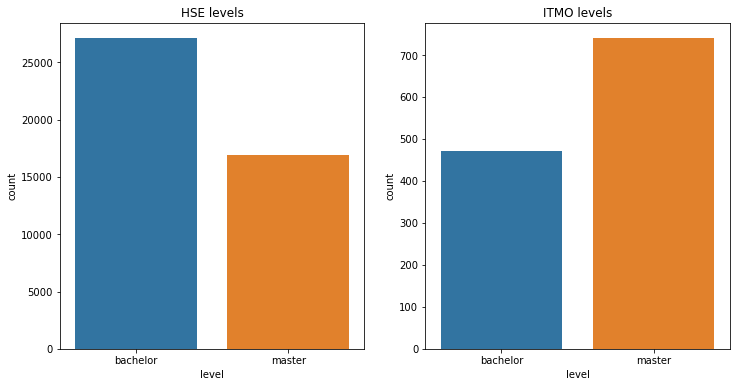

In [25]:
def plot_levels(df: pd.DataFrame, title: str, ax):
    ax.set_title(title)

    groups = df[["level", "title"]].groupby("level", as_index=False).count() \
        .rename(columns=rename_title)
    sns.barplot(x="level", y="count", data=groups, ax=ax)


with add_subplots(1, 2, figsize=(12, 6)) as (hse_ax, itmo_ax):
    plot_levels(transformed_hse_df, "HSE levels", hse_ax)
    plot_levels(transformed_itmo_df, "ITMO levels", itmo_ax)

## plot time progressions

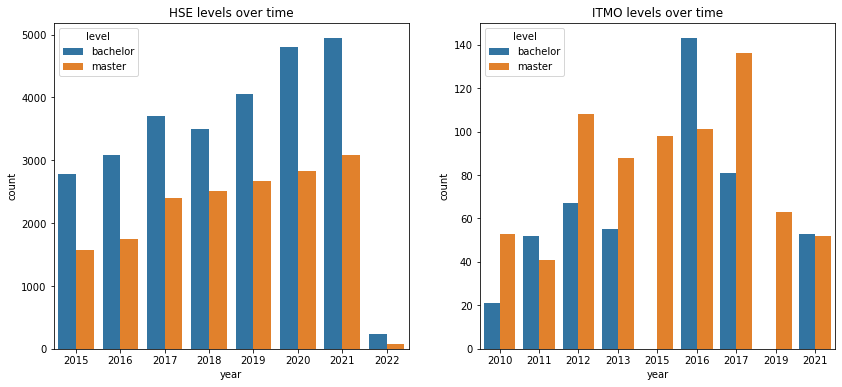

In [26]:
def plot_levels_over_time(df: pd.DataFrame, title: str, ax):
    groups = df[["year", "level", "title"]] \
        .groupby(["year", "level"], as_index=False) \
        .count().rename(columns=rename_title)
    ax.set_title(title)
    sns.barplot(x="year", y="count", hue="level", data=groups, ax=ax)


with add_subplots(1, 2, figsize=(14, 6)) as (hse_ax, itmo_ax):
    plot_levels_over_time(transformed_hse_df, "HSE levels over time", hse_ax)
    plot_levels_over_time(transformed_itmo_df, "ITMO levels over time", itmo_ax)

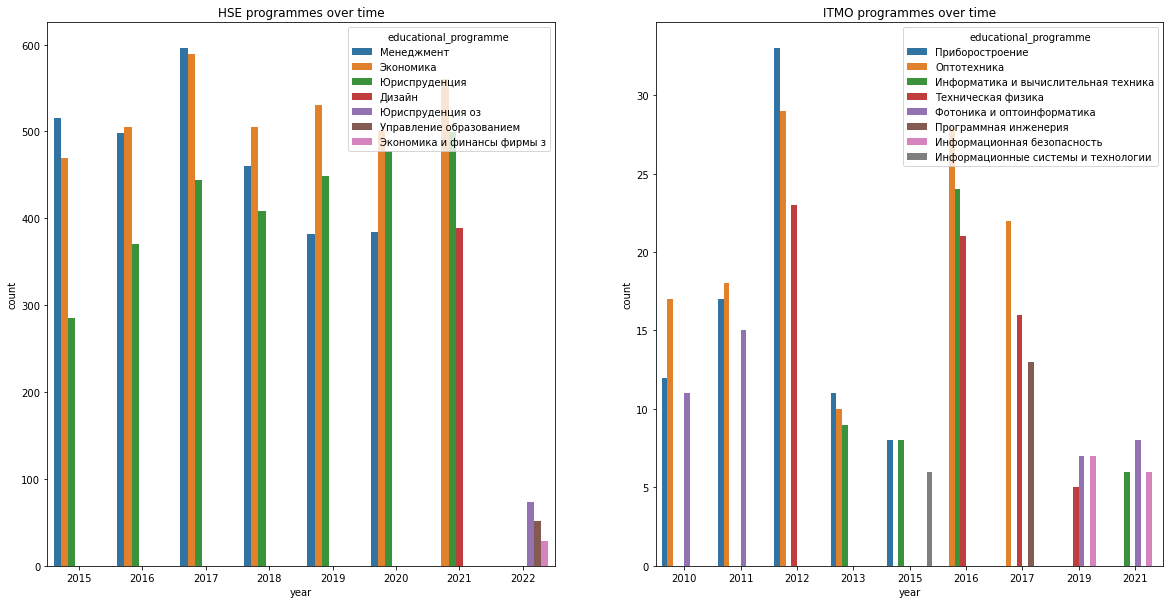

In [27]:
def plot_programmes_over_time(df: pd.DataFrame, title: str, ax, n_year: int = 3):
    groups = df[["year", "educational_programme", "title"]] \
        .groupby(["year", "educational_programme"], as_index=False).count() \
        .sort_values(by="title", ascending=False) \
        .groupby("year", as_index=False) \
        .head(n_year).rename(columns=rename_title)
    ax.set_title(title)
    sns.barplot(x="year", y="count", hue="educational_programme", data=groups, ax=ax)


with add_subplots(1, 2, figsize=(20, 10)) as (hse_ax, itmo_ax):
    plot_programmes_over_time(transformed_hse_df, "HSE programmes over time", hse_ax)
    plot_programmes_over_time(transformed_itmo_df, "ITMO programmes over time", itmo_ax)

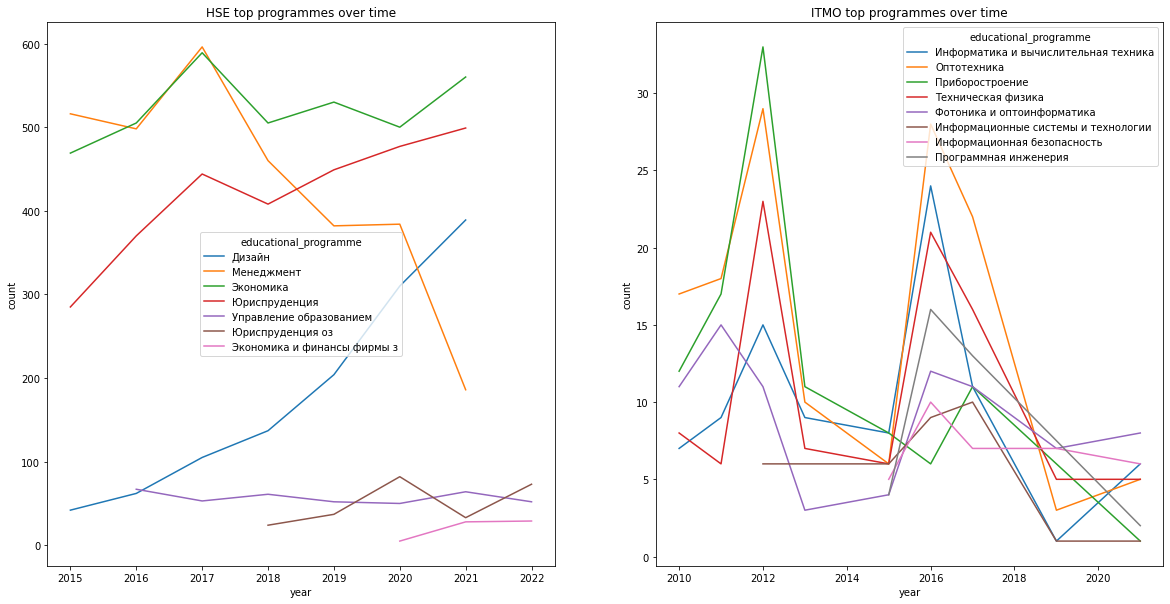

In [28]:
def plot_top_programmes_over_time(df: pd.DataFrame, title: str, ax, n_year: int = 3, n_window: int = 3):
    year_popularity_groups = df[["year", "educational_programme", "title"]] \
        .groupby(["year", "educational_programme"], as_index=False).count()
    year_popularity_groups = year_popularity_groups.sort_values(by="title", ascending=False) \
        .groupby("year").head(n_year)
    most_popular_programmes = year_popularity_groups["educational_programme"].unique()

    groups = df.loc[df["educational_programme"] \
        .isin(most_popular_programmes), ["year", "educational_programme", "title"]] \
        .groupby(["year", "educational_programme"], as_index=False) \
        .count().sort_values("year", ascending=True) \
        .rename(columns=rename_title)
    
    ax.set_title(title)
    sns.lineplot(x="year", y="count", hue="educational_programme", data=groups, ax=ax)


with add_subplots(1, 2, figsize=(20, 10)) as (hse_ax, itmo_ax):
    plot_top_programmes_over_time(transformed_hse_df, "HSE top programmes over time", hse_ax)
    plot_top_programmes_over_time(transformed_itmo_df, "ITMO top programmes over time", itmo_ax)

In [49]:
def plot_column_correlation_over_time(
    df: pd.DataFrame, column: str,
    n_head: int = 3, n_tail: int = 3
):
    programmes_groups = df[[column, "title"]] \
        .groupby(column, as_index=False) \
        .count().sort_values("title", ascending=False)
    
    top_programmes = programmes_groups.head(n_head)[column].tolist()
    bot_programmes = programmes_groups.tail(n_tail)[column].tolist()
    print(f"First {n_head} `{column}` values: {top_programmes}")
    print(f"Last {n_tail} `{column}` values: {bot_programmes}")

    target_programmes = top_programmes + bot_programmes

    groups = df.loc[df[column] \
        .isin(target_programmes), ["year", column, "title"]] \
        .groupby([column, "year"]).count().rename(columns=rename_title) \
        .reset_index(level=column)
    
    for programme in target_programmes:
        groups[programme] = groups.loc[groups[column] == programme, ["count"]].astype(int)
    
    groups.fillna(value=0, inplace=True)
    groups.drop(columns=[column, "count"], inplace=True)
    groups.drop_duplicates(inplace=True)
    
    sns.pairplot(data=groups, kind="reg", height=3)

First 3 `educational_programme` values: ['Экономика', 'Менеджмент', 'Юриспруденция']
Last 3 `educational_programme` values: ['Прикладная и междисциплинарная история', 'Когнитивные науки и технологии от нейрона к познанию', 'Системы больших данных']


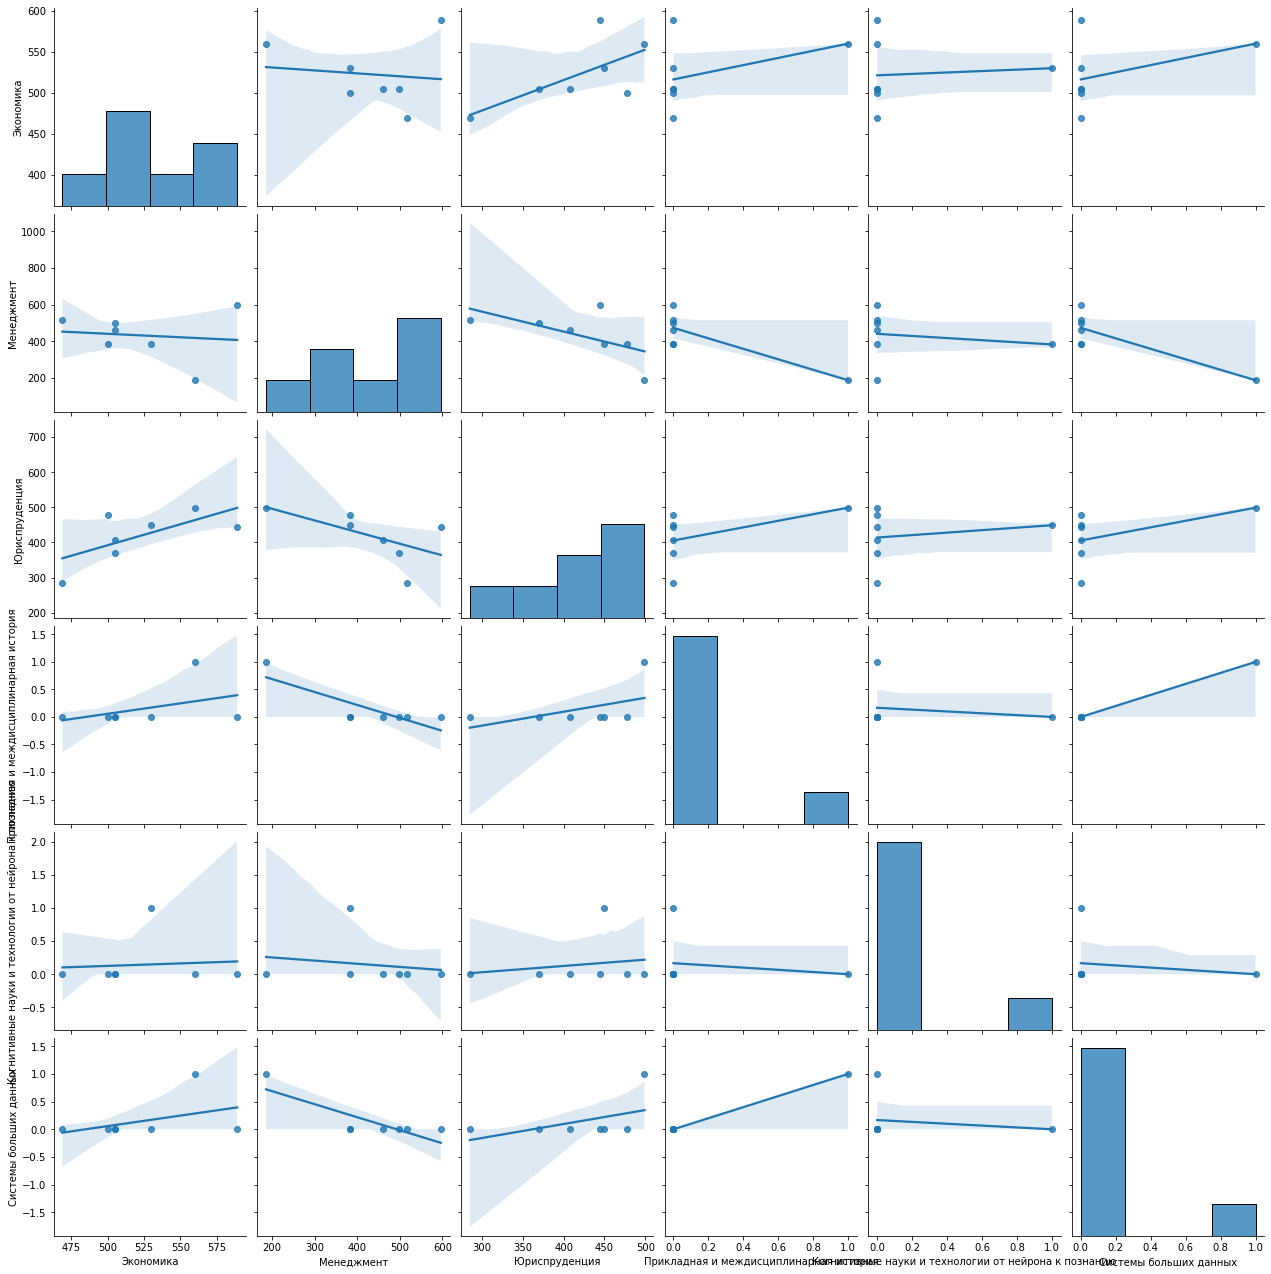

In [50]:
plot_column_correlation_over_time(transformed_hse_df, column="educational_programme")

First 3 `educational_programme` values: ['Оптотехника', 'Приборостроение', 'Техническая физика']
Last 3 `educational_programme` values: ['Математическое моделирование и прогнозирование информационных угроз', 'Лазерные микро и нанотехнологии', 'фотоника и оптоинформатика']


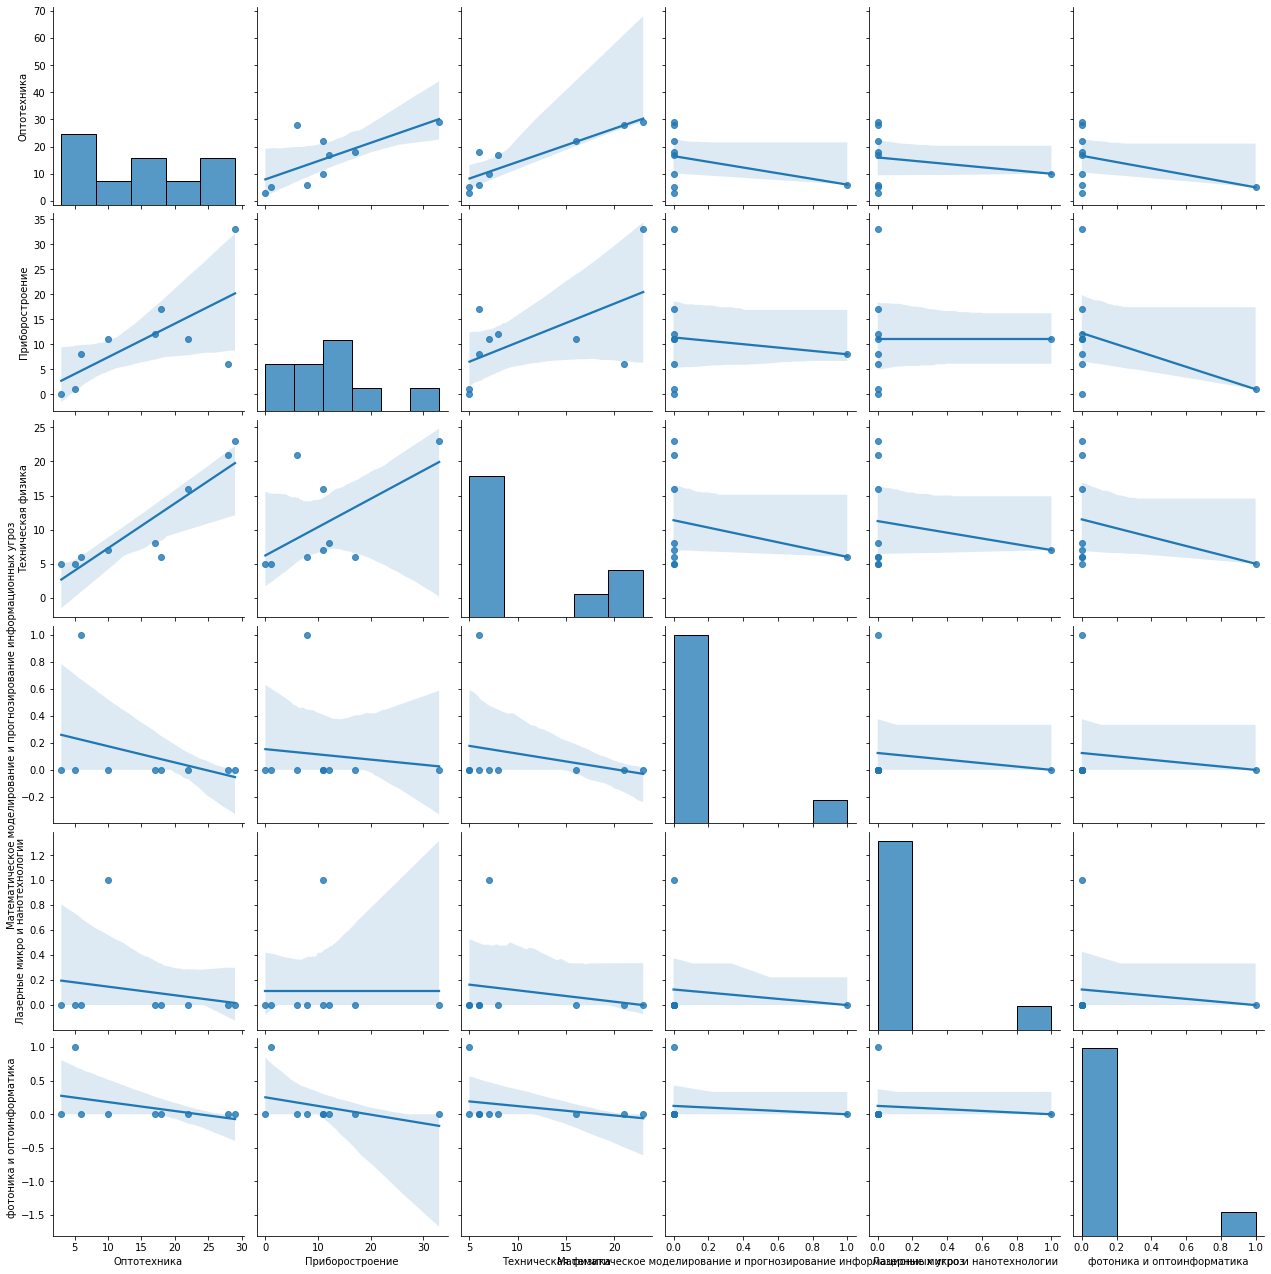

In [51]:
plot_column_correlation_over_time(transformed_itmo_df, column="educational_programme")

First 3 `faculty` values: ['Высшая школа бизнеса', 'Факультет социальных наук', 'Факультет коммуникаций']
Last 3 `faculty` values: ['Факультет менеджмента (Санкт-Петербург)', 'Факультет подготовки', 'Институт когнитивных нейронаук']


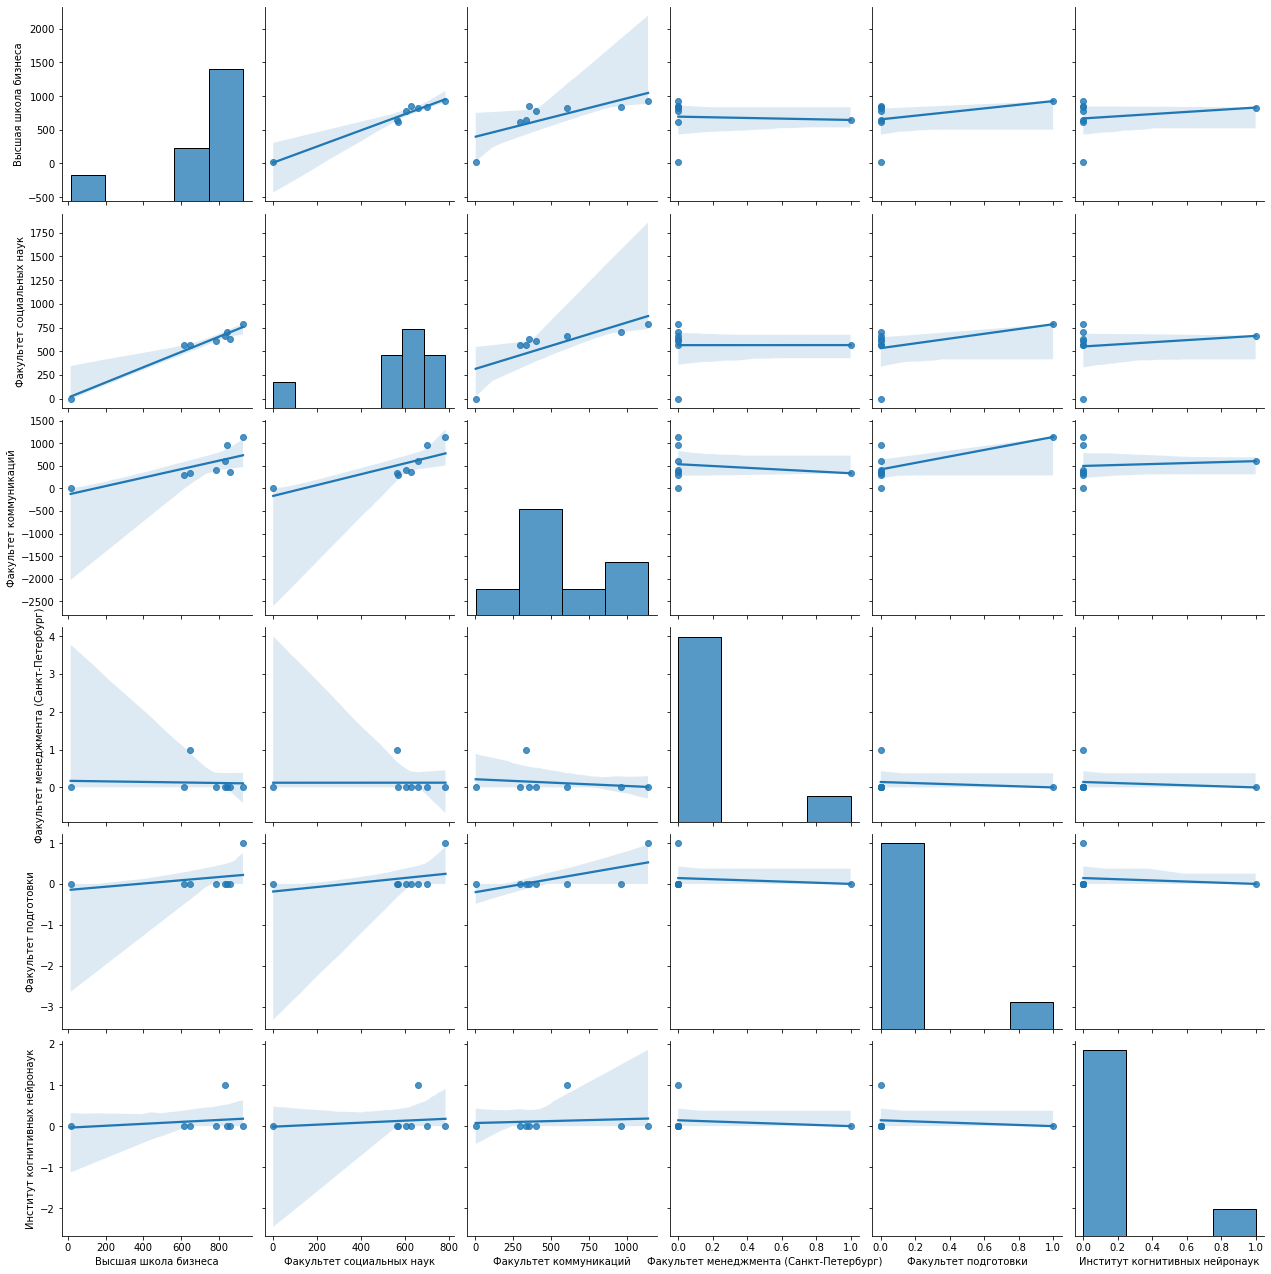

In [52]:
plot_column_correlation_over_time(transformed_hse_df, column="faculty")

First 3 `faculty` values: ['', 'Факультет лазерной и световой инженерии', 'Факультет компьютерных технологий и управления']
Last 3 `faculty` values: ['Факультет систем управления и регулирования', 'Факультет фотоники иоптоинформатики', 'Факультет информационных технологий механики и оптики']


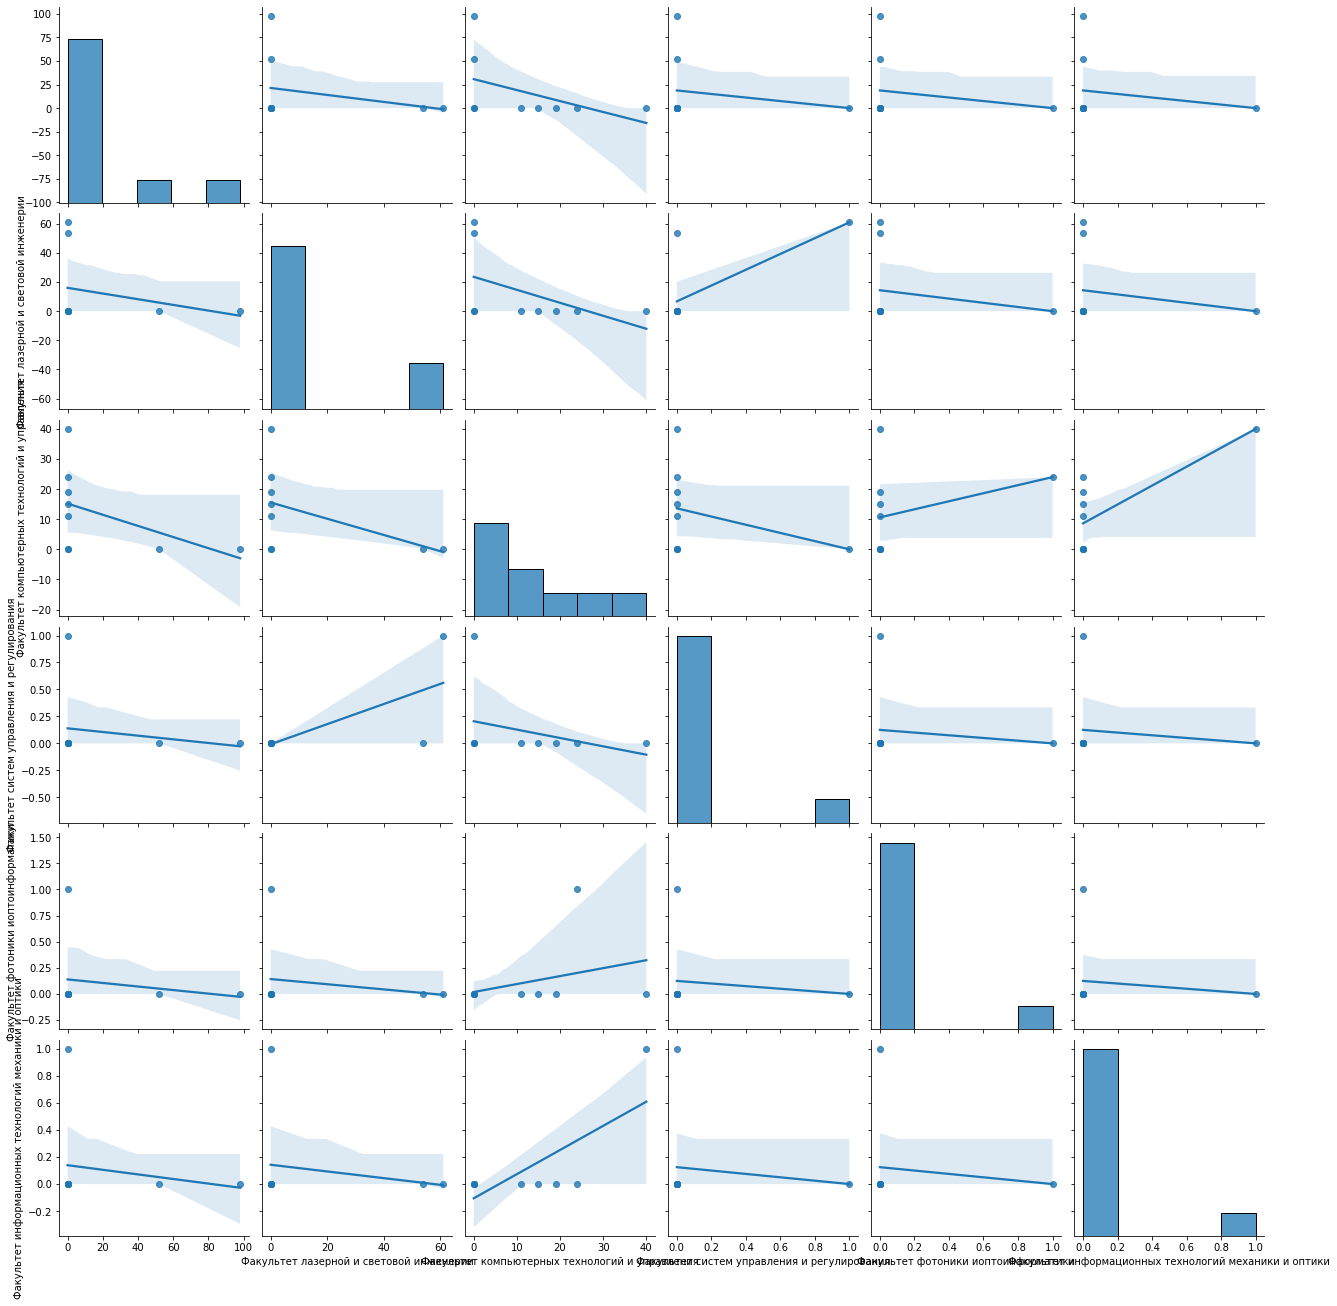

In [53]:
plot_column_correlation_over_time(transformed_itmo_df, column="faculty")